In [166]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization, LeakyReLU
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import time
import cv2
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras import models, layers
import matplotlib.pyplot as plt
import os, random

In [167]:
directory = 'embryos'

### Rotate images

In [208]:
directory = 'embryos' # File where I copied all embryos
images = []
for filename in os.listdir(directory):
    file = os.path.join(directory, filename)
    image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    images.append(image)

In [211]:
from scipy import ndimage
for i in range(122):    
    for degree in range(0, 450, 90): # 450 because I want to include 360 
        rotated_img = ndimage.rotate(images[i], degree)
        plt.imshow(rotated_img, cmap=plt.cm.gray)
        plt.axis('off')
        cv2.imwrite(f'rotated_embryos/embryo_{i}_{degree}.jpg', rotated_img)
    plt.show()

I created file where I divided cells according to cell cycle 0 is interphase, 1 is for mitosis

In [287]:
# Import data and split to train and test with validation split
ds_train = tf.keras.preprocessing.image_dataset_from_directory('embryos_binary',
                                                              labels='inferred',
                                                              label_mode ='int',
                                                              class_names = ['0', '1'],
                                                              color_mode = 'grayscale',
                                                              image_size = (256, 256),
                                                              shuffle = True,
                                                              seed = 123)

Found 1157 files belonging to 2 classes.


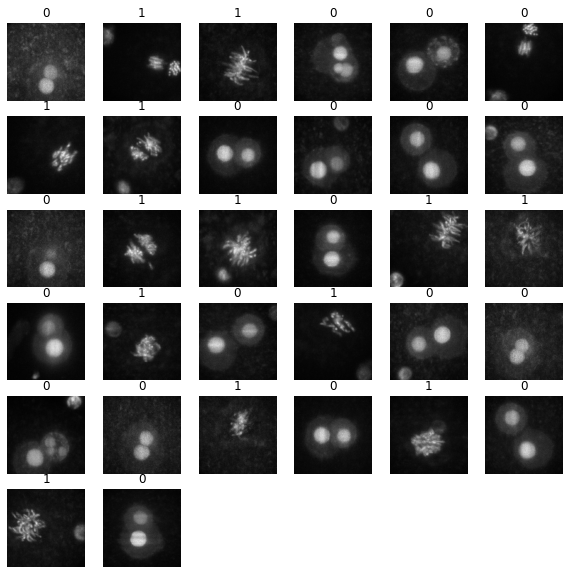

In [288]:
# Show images with labels
plt.figure(figsize=(10, 10))
class_names = ds_train.class_names
for images, labels in ds_train.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [289]:
data_iterator = ds_train.as_numpy_iterator()

In [290]:
batch = data_iterator.next()

In [2]:
# Rescale to 0-1
ds_train = ds_train.map(lambda x, y: (x/255, y))

In [293]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2))),
model.add(layers.ZeroPadding2D(padding=(1, 1))),
model.add(layers.Conv2D(32, (3, 3), activation='relu')),
model.add(layers.MaxPooling2D((2, 2))),
model.add(layers.Conv2D(16, (3, 3), activation='relu')),
model.add(layers.MaxPooling2D((2, 2))),
model.add(layers.Flatten()),
model.add(layers.Dense(256, activation='relu')),
model.add(Dense(units=1, activation='sigmoid'))

In [294]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 zero_padding2d_18 (ZeroPadd  (None, 129, 129, 16)     0         
 ing2D)                                                          
                                                                 
 conv2d_55 (Conv2D)          (None, 127, 127, 32)      4640      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                     

In [295]:
train_size = int(len(ds_train)*.7) 
test_size = int(len(ds_train)*.2) 
val_size = int(len(ds_train)*.1) 

In [296]:
train = ds_train.take(train_size)
val = ds_train.skip(train_size).take(val_size)
test = ds_train.skip(train_size+val_size).take(test_size)

In [298]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
hist = model.fit(train, epochs=30, verbose=1, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30
25/25 [==============================] - 25s 974ms/step - loss: 0.4495 - accuracy: 0.7625 - val_loss: 0.2213 - val_accuracy: 0.8854
Epoch 2/30
25/25 [==============================] - 20s 793ms/step - loss: 0.1657 - accuracy: 0.9425 - val_loss: 0.0811 - val_accuracy: 0.9792
Epoch 3/30
25/25 [==============================] - 17s 679ms/step - loss: 0.1017 - accuracy: 0.9663 - val_loss: 0.3740 - val_accuracy: 0.8438
Epoch 4/30
25/25 [==============================] - 17s 673ms/step - loss: 0.1831 - accuracy: 0.9325 - val_loss: 0.0775 - val_accuracy: 0.9688
Epoch 5/30
25/25 [==============================] - 17s 675ms/step - loss: 0.0422 - accuracy: 0.9887 - val_loss: 0.0350 - val_accuracy: 0.9792
Epoch 6/30
25/25 [==============================] - 18s 709ms/step - loss: 0.0198 - accuracy: 0.9950 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 7/30
25/25 [==============================] - 21s 850ms/step - loss: 0.0228 - accuracy: 0.9925 - val_loss: 0.0423 - val_accuracy: 0.9688

In [408]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [299]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [300]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [302]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 280ms/step


In [304]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9888888597488403, Recall: 1.0, Accuracy: 0.9955357313156128


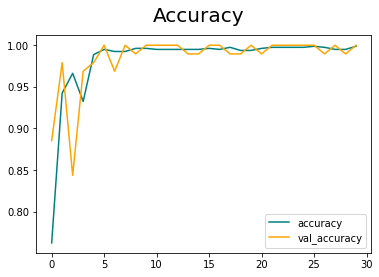

In [418]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='lower left')
plt.show()

## Predict length of mitosis on unseen data

In [428]:
images = []
for i in range(46):
    img = cv2.imread(f'embryo_18_jpg/embryo_18_{i}.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray.reshape(256, 256, 1)
    image = np.expand_dims(gray/255, 0)
    images.append(image)

In [429]:
predictions = []
for i in range(len(images)):
    y_pred = model.predict(images[i])
    y_pred[y_pred <= 0.5] = 0.
    y_pred[y_pred > 0.5] = 1.
    predictions.append(y_pred)

1/1 [==============================] - 0s 31ms/step


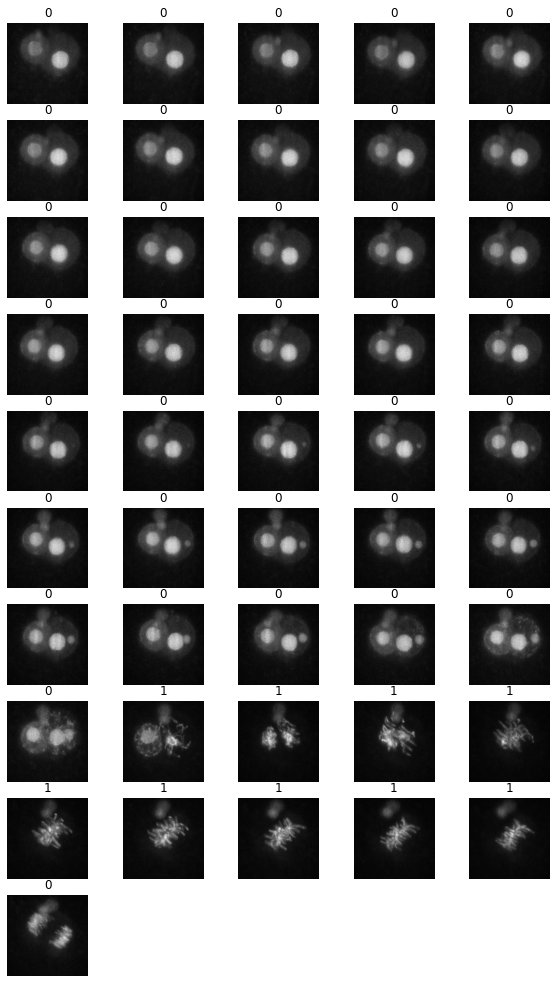

In [430]:
plt.figure(figsize=(10, 30))
for i in range(46):
    ax = plt.subplot(17, 5, i + 1)
    plt.imshow(images[i].reshape(256, 256),cmap='gray')
    plt.title(round(predictions[i][0][0]))
    plt.tight_layout
    plt.axis("off")

In [431]:
print(f'Length of mitosis is {sum([x == 1 for x in predictions])[0][0] * 5} minutes')

Length of mitosis is 45 minutes


In [432]:
images = []
for i in range(20):
    img = cv2.imread(f'embryo_10_jpg/embryo_10_{i}.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray.reshape(256, 256, 1)
    image = np.expand_dims(gray/255, 0)
    images.append(image)

In [433]:
predictions = []
for i in range(len(images)):
    y_pred = model.predict(images[i])
    y_pred[y_pred <= 0.5] = 0.
    y_pred[y_pred > 0.5] = 1.
    predictions.append(y_pred)

1/1 [==============================] - 0s 47ms/step


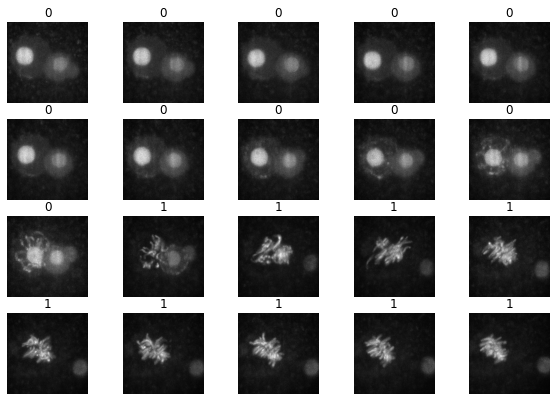

In [435]:
plt.figure(figsize=(10, 30))
for i in range(20):
    ax = plt.subplot(17, 5, i + 1)
    plt.imshow(images[i].reshape(256, 256),cmap='gray')
    plt.title(round(predictions[i][0][0]))
    plt.tight_layout
    plt.axis("off")

In [436]:
print(f'Length of mitosis is {sum([x == 1 for x in predictions])[0][0] * 5} minutes')

Length of mitosis is 45 minutes
